In [1]:
import yaml
import pickle
import pandas as pd
import numpy as np
import lightgbm as lgb
import math


In [2]:
with open('..\params.yaml', 'r') as fd:
    params = yaml.safe_load(fd)

In [3]:
pickledir = params['prepare-step2']['pickle-dir']
with open(pickledir, 'rb') as fd:
    each_faction_dataset = pickle.load(fd)


In [4]:
feats = each_faction_dataset['auren']['features']

In [5]:
y_data = np.array(each_faction_dataset['auren']['vp'])

In [6]:
type(y_data)

numpy.ndarray

In [7]:
y_data.shape

(11610,)

In [8]:
faction = 'swarmlings'

In [9]:
Xdata = each_faction_dataset[faction]['features']
Xdata.drop(['Unnamed: 0', 'game'], axis=1)
traindata = lgb.Dataset(Xdata,
                        label=np.array(each_faction_dataset[faction]['vp']))

In [10]:
Xdata = each_faction_dataset[faction]['features']
Xdata = Xdata.drop(['Unnamed: 0', 'game'], axis=1)
Xdata.shape

(27967, 71)

In [11]:
Xdata.columns

Index(['r1_SCORE1', 'r1_SCORE2', 'r1_SCORE3', 'r1_SCORE4', 'r1_SCORE5',
       'r1_SCORE6', 'r1_SCORE7', 'r1_SCORE8', 'r1_SCORE9', 'r2_SCORE1',
       'r2_SCORE2', 'r2_SCORE3', 'r2_SCORE4', 'r2_SCORE5', 'r2_SCORE6',
       'r2_SCORE7', 'r2_SCORE8', 'r2_SCORE9', 'r3_SCORE1', 'r3_SCORE2',
       'r3_SCORE3', 'r3_SCORE4', 'r3_SCORE5', 'r3_SCORE6', 'r3_SCORE7',
       'r3_SCORE8', 'r3_SCORE9', 'r4_SCORE1', 'r4_SCORE2', 'r4_SCORE3',
       'r4_SCORE4', 'r4_SCORE5', 'r4_SCORE6', 'r4_SCORE7', 'r4_SCORE8',
       'r4_SCORE9', 'r5_SCORE1', 'r5_SCORE2', 'r5_SCORE3', 'r5_SCORE4',
       'r5_SCORE5', 'r5_SCORE6', 'r5_SCORE7', 'r5_SCORE8', 'r5_SCORE9',
       'r6_SCORE1', 'r6_SCORE2', 'r6_SCORE3', 'r6_SCORE4', 'r6_SCORE5',
       'r6_SCORE6', 'r6_SCORE7', 'r6_SCORE8', 'r6_SCORE9', 'BON1', 'BON2',
       'BON3', 'BON4', 'BON5', 'BON6', 'BON7', 'BON8', 'BON9', 'BON10',
       '2players', '3players', '4players', '5players', 'map1', 'map2', 'map3'],
      dtype='object')

In [50]:
trainlen = math.ceil(Xdata.shape[0] * 0.8)
vallen = math.ceil(Xdata.shape[0] * 0.9)
traindata = Xdata.iloc[:trainlen, :]
trainy = np.array(each_faction_dataset[faction]['vp'].iloc[:trainlen])
valdata = Xdata.iloc[trainlen:vallen, :]
valy = np.array(each_faction_dataset[faction]['vp'].iloc[trainlen:vallen])
testdata = Xdata.iloc[vallen:, :]
testy = np.array(each_faction_dataset[faction]['vp'].iloc[vallen:])
print(traindata.shape)
print(valdata.shape)
print(testdata.shape)

(22374, 71)
(2797, 71)
(2796, 71)


In [23]:
test = each_faction_dataset[faction]['vp']

In [28]:
test.iloc[0]

102.0

In [30]:
traindataset = lgb.Dataset(traindata, label=trainy)
valdataset = traindataset.create_valid(valdata, label=valy)

In [142]:
len(np.array(each_faction_dataset[faction]['vp']))

27967

In [37]:
bst = lgb.LGBMRegressor(num_leaves=300)
bst.fit(traindata, trainy, eval_set=[(valdata, valy)] , eval_metric='mae', early_stopping_rounds=200)

[1]	valid_0's l1: 20.3545	valid_0's l2: 709.713
Training until validation scores don't improve for 200 rounds
[2]	valid_0's l1: 20.0793	valid_0's l2: 694.389
[3]	valid_0's l1: 19.8555	valid_0's l2: 680.875
[4]	valid_0's l1: 19.6851	valid_0's l2: 671.005
[5]	valid_0's l1: 19.5541	valid_0's l2: 662.465
[6]	valid_0's l1: 19.4446	valid_0's l2: 656.091
[7]	valid_0's l1: 19.3503	valid_0's l2: 650.802
[8]	valid_0's l1: 19.2779	valid_0's l2: 646.24
[9]	valid_0's l1: 19.2079	valid_0's l2: 642.429
[10]	valid_0's l1: 19.1416	valid_0's l2: 638.761
[11]	valid_0's l1: 19.0993	valid_0's l2: 636.539
[12]	valid_0's l1: 19.0643	valid_0's l2: 634.241
[13]	valid_0's l1: 19.03	valid_0's l2: 631.979
[14]	valid_0's l1: 19.0054	valid_0's l2: 630.312
[15]	valid_0's l1: 18.9859	valid_0's l2: 628.386
[16]	valid_0's l1: 18.972	valid_0's l2: 626.913
[17]	valid_0's l1: 18.9714	valid_0's l2: 626.352
[18]	valid_0's l1: 18.9608	valid_0's l2: 625.366
[19]	valid_0's l1: 18.9581	valid_0's l2: 624.566
[20]	valid_0's l1: 1

LGBMRegressor(num_leaves=300)

In [79]:
num_round=1000
param = {'num_leaves': 100, 'objective': 'regression'}
bst = lgb.train(param, traindataset, num_round)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 22374, number of used features: 69
[LightGBM] [Info] Start training from score 101.216367


In [75]:
testdata.shape

(2796, 71)

In [80]:
ypred = bst.predict(testdata)

In [81]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [82]:
MAE = metrics.mean_absolute_error(ypred, testy)
MAE

19.972878529976665

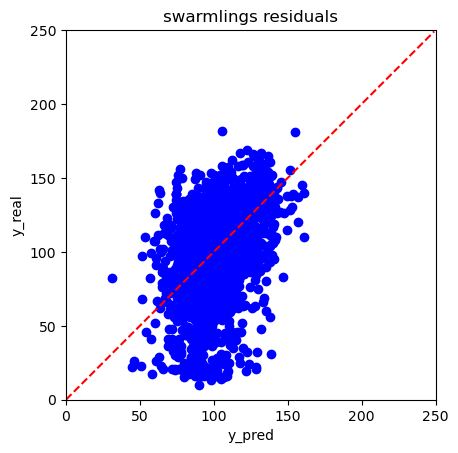

In [83]:
line = list(range(250))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'{faction} residuals')
plt.plot(ypred, testy, 'bo', line, line, 'r--')
plt.xlabel('y_pred')
plt.ylabel('y_real')
plt.xlim([0, 250])
plt.ylim([0, 250])
plt.show()

In [84]:
residuals = np.array(ypred) - np.array(testy)
avgres = np.mean(residuals)
original = np.array(testy) - np.mean(testy)
maxorig = math.ceil(np.max(original))
minorig = math.floor(np.min(original))
bins_list = list(range(minorig, maxorig))

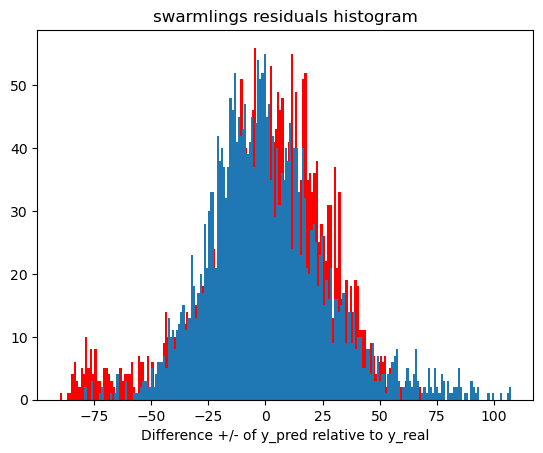

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(f'{faction} residuals histogram')
plt.hist(original, bins=bins_list, color='r')
plt.hist(residuals, bins=200)
plt.xlabel('Difference +/- of y_pred relative to y_real')
#h = ax.plot([avgres, avgres], [0, 600], 'r--')
plt.show()

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_aspect('equal', adjustable='box')
ax1.set_title(f'{faction} residuals')
ax1.plot(ypred, np.array(testy, 'bo', line, line, 'r--')
ax1.set(xlabel='y_pred', ylabel='y_real')
ax1.set(xlim=[0, 250], ylim=[0, 250])

ax2.set_title(f'{faction} residuals histogram')
ax2.hist(residuals, bins=100)
ax2.set(xlabel='Difference +/- of y_pred relative to y_real')
h = ax2.plot([avgres, avgres], [0, 600], 'r--')
plt.show()

SyntaxError: invalid syntax (<ipython-input-58-3d01449f4790>, line 5)

In [ ]:
# metricsdir = 'data/faction-picker-bot/metrics/'
# plt.savefig(metricsdir + f'{faction} charts.png')